# Composite Bloq Manipulation
[`CompositeBloq`](/reference/qualtran/CompositeBloq.md) is our primary container class for writing quantum programs. 

The [`Bloq`](/reference/qualtran/Bloq.md) interface describes a black-box quantum operation that guarantees certain input and output registers (i.e. a signature) and can be annotated with known quantities (like resource counts). A special type of [`Bloq`](/reference/qualtran/Bloq.md) is [`CompositeBloq`](/reference/qualtran/CompositeBloq.md). Instead of having its own name, attributes, resource counts, and others, it is a container class that is simply a collection of sub-bloqs. Specifically, it encodes a graph where we not only include the sub-bloqs but which outputs are connected to which inputs. 

In [1]:
from typing import *
import numpy as np

## Bloq Builder
Let's see how we can take an example [`Bloq`](/reference/qualtran/Bloq.md), create two instances of them, and wire them up in two different ways.

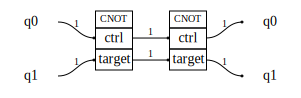

In [2]:
from qualtran import Bloq, BloqBuilder, Signature, Soquet
from qualtran.drawing import show_bloq

# An example Bloq:
from qualtran.bloqs.basic_gates import CNOT
bloq = CNOT()

# Wire up (way 1)
bb = BloqBuilder()
q0 = bb.add_register('q0', 1)
q1 = bb.add_register('q1', 1)
q0, q1 = bb.add(bloq, ctrl=q0, target=q1)
q0, q1 = bb.add(bloq, ctrl=q0, target=q1)
cbloq = bb.finalize(q0=q0, q1=q1)
show_bloq(cbloq)

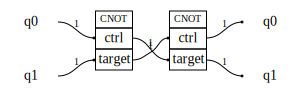

In [3]:
# Wire up (way 2)
bb = BloqBuilder()
q0 = bb.add_register('q0', 1)
q1 = bb.add_register('q1', 1)
q0, q1 = bb.add(bloq, ctrl=q0, target=q1)
q0, q1 = bb.add(bloq, ctrl=q1, target=q0) ## !!
cbloq = bb.finalize(q0=q0, q1=q1)
show_bloq(cbloq)

We declare our external-facing registers to be named `q0` and `q1`. By choice, we likewise name our quantum variables `q0` and `q1` throughout, pass them as keyword arguments to `add`, and receive *new* quantum variables to which we re-assign the names `q0` and `q1`.

In the highlighted line in "way 2", we use the control output from the first bloq instance as the `target` input to the second bloq instance (causing the crossing of lines in the diagram). We still bind the output of the second `control` register to the composite bloq's `q0` register.

## Decompose Bloq

You can direcly contruct composite bloqs using [`BloqBuilder`](/reference/qualtran/BloqBuilder.md) per above. The other main use of composite bloqs is the return type of `Bloq.decompose_bloq()`. When defining a bloq, you can provide its decomposition by overriding the `build_composite_bloq` method. In this case, the bloq builder and registers are set up for you and you just need to add the operations.

In [4]:
class TestTwoCNOT(Bloq):
    @property
    def signature(self) -> Signature:
        return Signature.build(q1=1, q2=1)

    def build_composite_bloq(
        self, bb: 'BloqBuilder', q1: 'Soquet', q2: 'Soquet'
    ) -> Dict[str, 'Soquet']:
        q1, q2 = bb.add(CNOT(), ctrl=q1, target=q2)
        q1, q2 = bb.add(CNOT(), ctrl=q2, target=q1)
        return {'q1': q1, 'q2': q2}

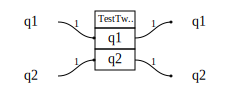

In [5]:
show_bloq(TestTwoCNOT())

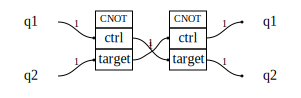

In [6]:
show_bloq(TestTwoCNOT().decompose_bloq())

## Debug Text

The graph structure is most easily viewed as a diagram, but composite bloqs also expose a textual description where each sub-bloq instance is printed in topologically-sorted order. Below each subbloq, the incoming (left) and outgoing (right) connections are printed.

In [7]:
print(cbloq.debug_text())

CNOT()<0>
  LeftDangle.q0 -> ctrl
  LeftDangle.q1 -> target
  target -> CNOT()<1>.ctrl
  ctrl -> CNOT()<1>.target
--------------------
CNOT()<1>
  CNOT()<0>.target -> ctrl
  CNOT()<0>.ctrl -> target
  ctrl -> RightDangle.q0
  target -> RightDangle.q1


## Valid Decomposition

We can use various assertion helpers to check that a given composite bloq is valid, i.e. that it follows the invariants of the data structure. 

In [8]:
from qualtran.testing import (
    assert_registers_match_parent,
    assert_registers_match_dangling,
    assert_soquets_belong_to_registers,
    assert_soquets_used_exactly_once,
    assert_connections_compatible
)

bloq = TestTwoCNOT()
assert_registers_match_parent(bloq)

cbloq = bloq.decompose_bloq()
assert_registers_match_dangling(cbloq)
assert_soquets_belong_to_registers(cbloq)
assert_soquets_used_exactly_once(cbloq)
assert_connections_compatible(cbloq)

Of course, we provide a helper function that does all of the checks in one call:

In [9]:
from qualtran.testing import assert_valid_bloq_decomposition

assert_valid_bloq_decomposition(bloq)
print("Checks out!")

Checks out!


## Iter Bloqnections

It can be useful to iterate over the graph in this form: namely bloq instances along with their predecessor and successor connections. Using `composite_bloq.iter_bloqnections()` we can quickly sketch a simple implementation of `debug_text()`. 

In [10]:
for binst, pred_cxns, succ_cxns in cbloq.iter_bloqnections():
    print(binst)
    for pred in pred_cxns:
        print('  ', pred.left, '->', pred.right)
    for succ in succ_cxns:
        print('  ', succ.left, '->', succ.right)

CNOT()<0>
   LeftDangle.q1 -> CNOT()<0>.ctrl
   LeftDangle.q2 -> CNOT()<0>.target
   CNOT()<0>.target -> CNOT()<1>.ctrl
   CNOT()<0>.ctrl -> CNOT()<1>.target
CNOT()<1>
   CNOT()<0>.target -> CNOT()<1>.ctrl
   CNOT()<0>.ctrl -> CNOT()<1>.target
   CNOT()<1>.ctrl -> RightDangle.q1
   CNOT()<1>.target -> RightDangle.q2


## Copy

We can perform a copy of a composite bloq, which will produce a new composite bloq whose bloq instances are different. This is an incredibly uninteresting operation in the abstract because CompositeBloqs are immutable. However, you can inspect the `copy` code to see how it forms the basis for more interesting copy-with-modification methods discussed later.

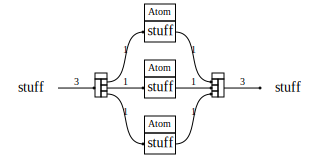

None

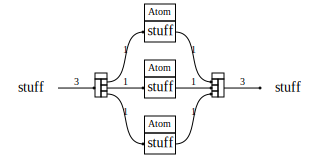

None

In [11]:
from qualtran._infra.composite_bloq_test import Atom, TestSerialBloq, TestParallelBloq

cbloq = TestParallelBloq().decompose_bloq()
cbloq2 = cbloq.copy()

# They're the same!
display(show_bloq(cbloq))
display(show_bloq(cbloq2))

To try to show that something is actually happening, we use the following monkey-patching code to override [`BloqBuilder`](/reference/qualtran/BloqBuilder.md)'s internal counter for numbering bloq instances so the copied version has different indices.

In [12]:
from contextlib import contextmanager

@contextmanager
def hacked_bb_init():
    # monkey-patch BloqBuilder to offset the bloq instance counter.
    
    old_bb_init_method = BloqBuilder.__init__
    
    def _new_init(self, *args, **kwargs):
        old_bb_init_method(self, *args, **kwargs)
        self._i = 100

    try:
        BloqBuilder.__init__ = _new_init
        yield
    finally:
        BloqBuilder.__init__ = old_bb_init_method

Now when we iterate through the original cbloq's connections and the copy's, we see that the connectivity is the same but the bloq instance indices are different.

In [13]:
cbloq = TestParallelBloq().decompose_bloq()

with hacked_bb_init():
    cbloq2 = cbloq.copy()

for cxn1, cxn2 in zip(cbloq.connections, cbloq2.connections):
    print(cxn1)
    print(cxn2)
    print()

LeftDangle.stuff -> Split(n=3)<0>.split
LeftDangle.stuff -> Split(n=3)<100>.split

Split(n=3)<0>.split[0] -> Atom()<1>.stuff
Split(n=3)<100>.split[0] -> Atom()<101>.stuff

Split(n=3)<0>.split[1] -> Atom()<2>.stuff
Split(n=3)<100>.split[1] -> Atom()<102>.stuff

Split(n=3)<0>.split[2] -> Atom()<3>.stuff
Split(n=3)<100>.split[2] -> Atom()<103>.stuff

Atom()<1>.stuff -> Join(n=3)<4>.join[0]
Atom()<101>.stuff -> Join(n=3)<104>.join[0]

Atom()<2>.stuff -> Join(n=3)<4>.join[1]
Atom()<102>.stuff -> Join(n=3)<104>.join[1]

Atom()<3>.stuff -> Join(n=3)<4>.join[2]
Atom()<103>.stuff -> Join(n=3)<104>.join[2]

Join(n=3)<4>.join -> RightDangle.stuff
Join(n=3)<104>.join -> RightDangle.stuff



## Iter Bloqsoqs

Under the hood of `CompositeBloq.copy()` and many of the methods that follow use `CompositeBloq.iter_bloqsoqs()` in coordination with `map_soqs` to iterate over the contents of a composite bloq in a form suitable for making a copy (optionally with modification). We reproduce the code used to implement `copy`.

In [14]:
from qualtran import SoquetT

# Start a new BloqBuilder to build up our copy
bb, _ = BloqBuilder.from_signature(cbloq.signature)

# We'll have to "map" the soquets from our template cbloq to our new one
soq_map: List[Tuple[SoquetT, SoquetT]] = []
    
# Iteration yields each bloq instance as well as its input and output soquets.
for binst, in_soqs, old_out_soqs in cbloq.iter_bloqsoqs():
    # We perform the mapping
    in_soqs = bb.map_soqs(in_soqs, soq_map)
    
    # Optional modification can go here!
    # We add a new bloq instance based on the template cbloq.
    # We use `bb.add_t` so the return value is always a tuple, even
    # if there's only one value returned.
    new_out_soqs = bb.add_t(binst.bloq, **in_soqs)
    
    # We are responsible for updating the mapping from old soquets (provided
    # to us) with our new soquets obtained from the bloq builder.
    soq_map.extend(zip(old_out_soqs, new_out_soqs))

# We finalize the new builder with a mapped version of the final,
# right-dangling soquets.
fsoqs = bb.map_soqs(cbloq.final_soqs(), soq_map)
copy = bb.finalize(**fsoqs)
copy

CompositeBloq(connections=(Connection(left=Soquet(binst=LeftDangle, reg=Register(name='stuff', bitsize=3, shape=(), side=<Side.THRU: 3>), idx=()), right=Soquet(binst=BloqInstance(bloq=Split(n=3), i=0), reg=Register(name='split', bitsize=3, shape=(), side=<Side.LEFT: 1>), idx=())), Connection(left=Soquet(binst=BloqInstance(bloq=Split(n=3), i=0), reg=Register(name='split', bitsize=1, shape=(3,), side=<Side.RIGHT: 2>), idx=(0,)), right=Soquet(binst=BloqInstance(bloq=Atom(), i=1), reg=Register(name='stuff', bitsize=1, shape=(), side=<Side.THRU: 3>), idx=())), Connection(left=Soquet(binst=BloqInstance(bloq=Split(n=3), i=0), reg=Register(name='split', bitsize=1, shape=(3,), side=<Side.RIGHT: 2>), idx=(1,)), right=Soquet(binst=BloqInstance(bloq=Atom(), i=2), reg=Register(name='stuff', bitsize=1, shape=(), side=<Side.THRU: 3>), idx=())), Connection(left=Soquet(binst=BloqInstance(bloq=Split(n=3), i=0), reg=Register(name='split', bitsize=1, shape=(3,), side=<Side.RIGHT: 2>), idx=(2,)), right=Soq

## Add from

We can use `bb.add_from` to add all the contents of a composite bloq to the current bloq-under-construction. This has the effect of flattening one level of structure during bloq construction. In the following cells, we connect `TestParallelBloq`s serially but vary when we call `bb.add` vs `bb.add_from`.

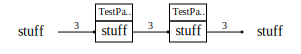

In [15]:
# Just call add
bb = BloqBuilder()
stuff = bb.add_register('stuff', 3)
stuff = bb.add(TestParallelBloq(), stuff=stuff)
stuff = bb.add(TestParallelBloq(), stuff=stuff)
bloq = bb.finalize(stuff=stuff)
show_bloq(bloq)

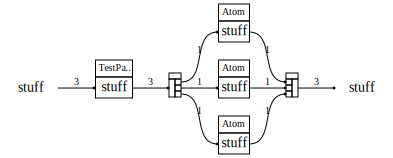

In [16]:
# `add_from` on second one
bb = BloqBuilder()
stuff = bb.add_register('stuff', 3)
stuff, = bb.add_t(TestParallelBloq(), stuff=stuff)
stuff, = bb.add_from(TestParallelBloq(), stuff=stuff)
bloq = bb.finalize(stuff=stuff)

show_bloq(bloq)

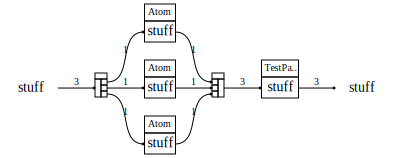

In [17]:
# `add_from` on first one
bb = BloqBuilder()
stuff = bb.add_register('stuff', 3)
stuff, = bb.add_from(TestParallelBloq(), stuff=stuff)
stuff, = bb.add_t(TestParallelBloq(), stuff=stuff)
bloq = bb.finalize(stuff=stuff)

show_bloq(bloq)

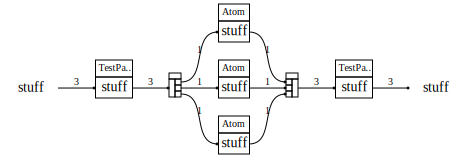

In [18]:
# `add_from` on middle one
bb = BloqBuilder()
stuff = bb.add_register('stuff', 3)
stuff, = bb.add_t(TestParallelBloq(), stuff=stuff)
stuff, = bb.add_from(TestParallelBloq().decompose_bloq(), stuff=stuff)
stuff, = bb.add_t(TestParallelBloq(), stuff=stuff)

bloq = bb.finalize(stuff=stuff)
show_bloq(bloq)

## Flatten

If we already have a composite bloq, we can "flatten" its subbloqs. The `flatten` and `flatten_once` methods take a predicate which can choose whether to flatten a bloq instance or keep it as-is.

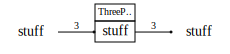

In [19]:
class ThreeParallelBloqs(Bloq):
    @property
    def signature(self) -> Signature:
        return Signature.build(stuff=3)

    def build_composite_bloq(
            self, bb: 'BloqBuilder', stuff: 'SoquetT'
    ) -> Dict[str, 'SoquetT']:
        stuff = bb.add(TestParallelBloq(), stuff=stuff)
        stuff = bb.add(TestParallelBloq(), stuff=stuff)
        stuff = bb.add(TestParallelBloq(), stuff=stuff)
        return {'stuff': stuff}

three_p = ThreeParallelBloqs().as_composite_bloq()
show_bloq(three_p)

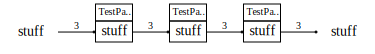

In [20]:
# Do one flattening iteration
flat_three_p = three_p.flatten_once(lambda binst: True)
show_bloq(flat_three_p)

If we just decomposed all of the subbloqs, our diagram would look very similar except the subbloqs are now [`CompositeBloq`](/reference/qualtran/CompositeBloq.md) container classes instead of the original `TestParallelBloq`.

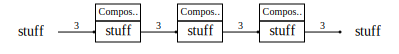

In [21]:
# Go through and decompose each subbloq
# We'll manually code this up in this notebook since this isn't a useful operation.
bb, _ = BloqBuilder.from_signature(flat_three_p.signature)
soq_map: List[Tuple[SoquetT, SoquetT]] = []
    
for binst, in_soqs, old_out_soqs in flat_three_p.iter_bloqsoqs():
    in_soqs = bb.map_soqs(in_soqs, soq_map)
    
    # Here, we call `decompose_bloq()` before adding in the subbloq
    new_out_soqs = bb.add_t(binst.bloq.decompose_bloq(), **in_soqs)
    soq_map.extend(zip(old_out_soqs, new_out_soqs))

fsoqs = bb.map_soqs(flat_three_p.final_soqs(), soq_map)
decompose_children = bb.finalize(**fsoqs)
show_bloq(decompose_children)

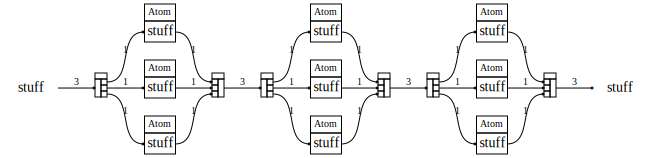

In [22]:
# Actually do a flattening operation on all the subbloqs
show_bloq(
    flat_three_p.flatten_once(lambda binst: True)
)

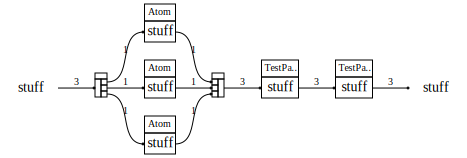

In [23]:
# Flatten by binst properties
show_bloq(
    flat_three_p.flatten_once(lambda binst: binst.i == 1)
)

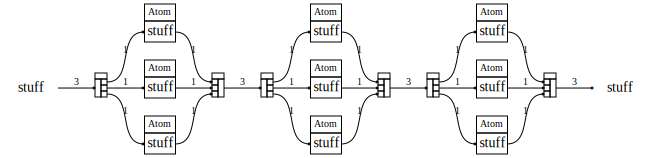

In [24]:
# Flatten until you can't flatten any more
show_bloq(
    three_p.flatten(lambda binst: binst.bloq.supports_decompose_bloq())
)

## Controlled

`ControlledBloq(subbloq)` represents a controlled version of `subbloq`. Its decompose method will call `subbloq`'s decompose and wrap each of the child bloqs in `ControlledBloq`.

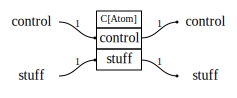

In [25]:
from qualtran.bloqs.controlled_bloq import ControlledBloq

bloq = ControlledBloq(subbloq=Atom())
show_bloq(bloq)

### Controlled Serial Bloq

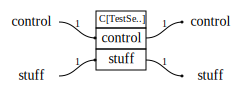

None

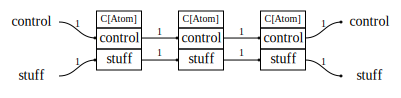

None

In [26]:
bloq = ControlledBloq(subbloq=TestSerialBloq())
display(show_bloq(bloq))
display(show_bloq(bloq.decompose_bloq()))

### Controlled Parallel Bloq

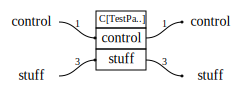

None

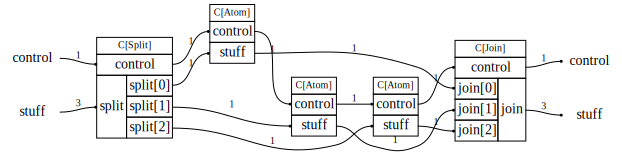

None

In [27]:
bloq = ControlledBloq(subbloq=TestParallelBloq())
display(show_bloq(bloq))
display(show_bloq(bloq.decompose_bloq()))